In [1]:
import pandas as pd
import dask.dataframe as dd
from BayDS.lib.utils import *
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# df = pd.read_pickle('./FE/TEMP/agg1.pkl')
# for col in df.columns:
#     if df[col].dtype.name == 'category':
#         df[col] = df[col].astype(str)
# df.to_parquet('./FE/agg1.pqt')

In [13]:
# qdf = pd.read_parquet('./FE/agg2.pqt')

In [15]:
# qdf['field7_count_groupby_field16bin'].values

array(['66807', '27822', '66807', ..., '105924', '42161', '42323'],
      dtype=object)

In [2]:
fe_files = ['./FE/agg1.pqt']#['./FE/agg.pqt', './FE/agg_12.pqt','./FE/agg2.pqt']

In [3]:
rating={}
# rating = pd.read_pickle('./temp/rating.pkl')


In [7]:
# len(rating.keys())
rating = {k:v for k,v in rating.items() if not k.endswith('bin')}

In [8]:
len(rating.keys())

5062

In [7]:
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
def individual_gini(feat, df, y, n_jobs):
    '''
    count individual Gini for feature
    :param feat: feature to count Gini for
    :param df: dataframe
    :param y: target series
    :param n_jobs: n_jobs
    :return: individual Gini
    '''
#     print(' feature: ', feat)

    if df[feat].dtypes == 'O':
        x = pd.get_dummies(df[feat]).values
        obvious_gini = 0
    else:
        #         print('\t  Counting obvious gini...')
        if df[feat].dtype.name in ('float32', 'float64'):
            df = df.replace([np.inf,-np.inf],np.nan)
            df = df.fillna(-9999999)
        x = np.array(df[feat].values).reshape(-1, 1)
        obvious_gini = round(abs(roc_auc_score(y, x) * 2 - 1), 3)

    #     print('\t  Now count gini using decision tree')
    parameters = {'min_weight_fraction_leaf':  [0.01, 0.025, 0.05, 0.1]}

    dt = DecisionTreeClassifier(random_state=0)
    cv = StratifiedKFold(3, random_state=0)
    clf = GridSearchCV(dt, parameters, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

#     print('\t  Run grid search...')
    clf.fit(x, y)

    true_gini = round(abs(clf.best_score_ * 2 - 1), 3)
    print('\t  True gini is ', true_gini)
    print('-------------------------------------------')

    return max(100 * obvious_gini, 100 * true_gini)

In [5]:
file = fe_files[0]

In [6]:
df = dd.read_parquet(file)


In [13]:
df.columns

Index(['userid', 'field0', 'field1', 'field2', 'field3', 'field4', 'field5',
       'field6', 'field7', 'field8',
       ...
       'field22_to_mean_has_children', 'field22_to_std_has_children',
       'field23_to_mean_has_children', 'field23_to_std_has_children',
       'field24_to_mean_has_children', 'field24_to_std_has_children',
       'field25_to_mean_has_children', 'field25_to_std_has_children',
       'field28_to_mean_has_children', 'field28_to_std_has_children'],
      dtype='object', length=827)

In [8]:
for file in fe_files:
    df = dd.read_parquet(file)
    for col in df.columns:
        if col in rating:
            continue
        if col.startswith('goal'):
            continue
        print(col)
        tmp = df[[col,'goal1']]
        df_single = tmp[tmp['goal1'] >= 0].compute()
        if df_single[col].dtypes == 'O':
            if len(df_single[col].value_counts())>100:
                print('skipping ', col)
                continue
        score = individual_gini(col,df_single,df_single['goal1'],-1)
        print(col,score)
        rating[col] = score
        pickle.dump(rating,open("./temp/rating1.pkl",'wb'))
#         break

userid
skipping  userid
field12
skipping  field12
order_till_hour
skipping  order_till_hour
order_till_weekday
skipping  order_till_weekday
lang_country
skipping  lang_country
field17_to_std_field7
	  True gini is  0.144
-------------------------------------------
field17_to_std_field7 14.399999999999999
field19_to_mean_field7
	  True gini is  0.125
-------------------------------------------
field19_to_mean_field7 12.5
field19_to_std_field7
	  True gini is  0.125
-------------------------------------------
field19_to_std_field7 12.5
field22_to_mean_field7
	  True gini is  0.143
-------------------------------------------
field22_to_mean_field7 14.299999999999999
field22_to_std_field7
	  True gini is  0.144
-------------------------------------------
field22_to_std_field7 14.399999999999999
field23_to_mean_field7
	  True gini is  0.139
-------------------------------------------
field23_to_mean_field7 13.900000000000002
field23_to_std_field7
	  True gini is  0.138
---------------------

	  True gini is  0.04
-------------------------------------------
field19_to_std_field10 4.0
field22_to_mean_field10
	  True gini is  0.157
-------------------------------------------
field22_to_mean_field10 15.7
field22_to_std_field10
	  True gini is  0.144
-------------------------------------------
field22_to_std_field10 14.399999999999999
field23_to_mean_field10
	  True gini is  0.037
-------------------------------------------
field23_to_mean_field10 3.6999999999999997
field23_to_std_field10
	  True gini is  0.039
-------------------------------------------
field23_to_std_field10 3.9
field24_to_mean_field10
	  True gini is  0.057
-------------------------------------------
field24_to_mean_field10 5.7
field24_to_std_field10
	  True gini is  0.057
-------------------------------------------
field24_to_std_field10 5.7
field25_to_mean_field10
	  True gini is  0.168
-------------------------------------------
field25_to_mean_field10 16.8
field25_to_std_field10
	  True gini is  0.168
--

	  True gini is  0.027
-------------------------------------------
field23_to_std_field26 2.7
field24_to_mean_field26
	  True gini is  0.048
-------------------------------------------
field24_to_mean_field26 4.8
field24_to_std_field26
	  True gini is  0.05
-------------------------------------------
field24_to_std_field26 5.0
field25_to_mean_field26
	  True gini is  0.141
-------------------------------------------
field25_to_mean_field26 14.099999999999998
field25_to_std_field26
	  True gini is  0.136
-------------------------------------------
field25_to_std_field26 13.600000000000001
field28_to_mean_field26
	  True gini is  0.015
-------------------------------------------
field28_to_mean_field26 1.5
field28_to_std_field26
	  True gini is  0.009
-------------------------------------------
field28_to_std_field26 0.8999999999999999
field0_to_mean_field27
	  True gini is  0.071
-------------------------------------------
field0_to_mean_field27 7.3999999999999995
field0_to_std_field27


	  True gini is  0.146
-------------------------------------------
field25_to_std_field29 14.6
field28_to_mean_field29
	  True gini is  0.007
-------------------------------------------
field28_to_mean_field29 0.8
field28_to_std_field29
	  True gini is  0.007
-------------------------------------------
field28_to_std_field29 0.8
field0_to_mean_userid
	  True gini is  0.1
-------------------------------------------
field0_to_mean_userid 10.0
field0_to_std_userid
	  True gini is  0.099
-------------------------------------------
field0_to_std_userid 9.9
field1_to_mean_userid
	  True gini is  0.033
-------------------------------------------
field1_to_mean_userid 3.3000000000000003
field1_to_std_userid
	  True gini is  0.097
-------------------------------------------
field1_to_std_userid 9.700000000000001
field6_to_mean_userid
	  True gini is  0.08
-------------------------------------------
field6_to_mean_userid 8.5
field6_to_std_userid
	  True gini is  0.042
---------------------------

	  True gini is  0.007
-------------------------------------------
field28_to_std_field0bin 0.8
field0_to_mean_field6bin
	  True gini is  0.074
-------------------------------------------
field0_to_mean_field6bin 7.3999999999999995
field0_to_std_field6bin
	  True gini is  0.073
-------------------------------------------
field0_to_std_field6bin 7.3999999999999995
field1_to_mean_field6bin
	  True gini is  0.123
-------------------------------------------
field1_to_mean_field6bin 12.3
field1_to_std_field6bin
	  True gini is  0.151
-------------------------------------------
field1_to_std_field6bin 15.4
field6_to_mean_field6bin
	  True gini is  0.091
-------------------------------------------
field6_to_mean_field6bin 9.1
field6_to_std_field6bin
	  True gini is  0.088
-------------------------------------------
field6_to_std_field6bin 8.799999999999999
field9_to_mean_field6bin
	  True gini is  0.003
-------------------------------------------
field9_to_mean_field6bin 0.3
field9_to_std_fie

	  True gini is  0.071
-------------------------------------------
field0_to_mean_field16bin 7.3
field0_to_std_field16bin
	  True gini is  0.072
-------------------------------------------
field0_to_std_field16bin 7.3999999999999995
field1_to_mean_field16bin
	  True gini is  0.188
-------------------------------------------
field1_to_mean_field16bin 18.8
field1_to_std_field16bin
	  True gini is  0.241
-------------------------------------------
field1_to_std_field16bin 24.099999999999998
field6_to_mean_field16bin
	  True gini is  0.087
-------------------------------------------
field6_to_mean_field16bin 8.7
field6_to_std_field16bin
	  True gini is  0.088
-------------------------------------------
field6_to_std_field16bin 8.799999999999999
field9_to_mean_field16bin
	  True gini is  0.008
-------------------------------------------
field9_to_mean_field16bin 0.8
field9_to_std_field16bin
	  True gini is  0.006
-------------------------------------------
field9_to_std_field16bin 0.6
field

	  True gini is  0.074
-------------------------------------------
field0_to_std_field22bin 7.3999999999999995
field1_to_mean_field22bin
	  True gini is  0.103
-------------------------------------------
field1_to_mean_field22bin 10.299999999999999
field1_to_std_field22bin
	  True gini is  0.164
-------------------------------------------
field1_to_std_field22bin 16.400000000000002
field6_to_mean_field22bin
	  True gini is  0.086
-------------------------------------------
field6_to_mean_field22bin 8.6
field6_to_std_field22bin
	  True gini is  0.089
-------------------------------------------
field6_to_std_field22bin 8.9
field9_to_mean_field22bin
	  True gini is  0.001
-------------------------------------------
field9_to_mean_field22bin 0.3
field9_to_std_field22bin
	  True gini is  0.001
-------------------------------------------
field9_to_std_field22bin 0.3
field11_to_mean_field22bin
	  True gini is  0.097
-------------------------------------------
field11_to_mean_field22bin 9.7000

	  True gini is  0.072
-------------------------------------------
field0_to_std_price1bin 7.3999999999999995
field1_to_mean_price1bin
	  True gini is  0.148
-------------------------------------------
field1_to_mean_price1bin 14.799999999999999
field1_to_std_price1bin
	  True gini is  0.145
-------------------------------------------
field1_to_std_price1bin 14.499999999999998
field6_to_mean_price1bin
	  True gini is  0.085
-------------------------------------------
field6_to_mean_price1bin 8.5
field6_to_std_price1bin
	  True gini is  0.085
-------------------------------------------
field6_to_std_price1bin 8.5
field9_to_mean_price1bin
	  True gini is  0.005
-------------------------------------------
field9_to_mean_price1bin 0.5
field9_to_std_price1bin
	  True gini is  0.005
-------------------------------------------
field9_to_std_price1bin 0.5
field11_to_mean_price1bin
	  True gini is  0.118
-------------------------------------------
field11_to_mean_price1bin 11.799999999999999
fi

	  True gini is  0.08
-------------------------------------------
field1_to_mean_order_till_hour 8.0
field1_to_std_order_till_hour
	  True gini is  0.144
-------------------------------------------
field1_to_std_order_till_hour 16.0
field6_to_mean_order_till_hour
	  True gini is  0.088
-------------------------------------------
field6_to_mean_order_till_hour 9.1
field6_to_std_order_till_hour
	  True gini is  0.089
-------------------------------------------
field6_to_std_order_till_hour 9.0
field9_to_mean_order_till_hour
	  True gini is  0.0
-------------------------------------------
field9_to_mean_order_till_hour 0.4
field9_to_std_order_till_hour
	  True gini is  0.0
-------------------------------------------
field9_to_std_order_till_hour 0.4
field11_to_mean_order_till_hour
	  True gini is  0.0
-------------------------------------------
field11_to_mean_order_till_hour 0.1
field11_to_std_order_till_hour
	  True gini is  0.0
-------------------------------------------
field11_to_std

	  True gini is  0.157
-------------------------------------------
field25_to_std_order_till_weekday 15.7
field28_to_mean_order_till_weekday
	  True gini is  0.008
-------------------------------------------
field28_to_mean_order_till_weekday 0.8
field28_to_std_order_till_weekday
	  True gini is  0.005
-------------------------------------------
field28_to_std_order_till_weekday 0.8
field0_to_mean_order_till_month
	  True gini is  0.072
-------------------------------------------
field0_to_mean_order_till_month 7.199999999999999
field0_to_std_order_till_month
	  True gini is  0.069
-------------------------------------------
field0_to_std_order_till_month 6.9
field1_to_mean_order_till_month
	  True gini is  0.109
-------------------------------------------
field1_to_mean_order_till_month 10.9
field1_to_std_order_till_month
	  True gini is  0.169
-------------------------------------------
field1_to_std_order_till_month 16.900000000000002
field6_to_mean_order_till_month
	  True gini is 

	  True gini is  0.071
-------------------------------------------
field23_to_std_lang_country 7.1
field24_to_mean_lang_country
	  True gini is  0.195
-------------------------------------------
field24_to_mean_lang_country 19.5
field24_to_std_lang_country
	  True gini is  0.186
-------------------------------------------
field24_to_std_lang_country 18.6
field25_to_mean_lang_country
	  True gini is  0.225
-------------------------------------------
field25_to_mean_lang_country 22.5
field25_to_std_lang_country
	  True gini is  0.234
-------------------------------------------
field25_to_std_lang_country 23.400000000000002
field28_to_mean_lang_country
	  True gini is  0.008
-------------------------------------------
field28_to_mean_lang_country 1.2
field28_to_std_lang_country
	  True gini is  0.011
-------------------------------------------
field28_to_std_lang_country 1.2
field0_to_mean_all_children
	  True gini is  0.072
-------------------------------------------
field0_to_mean_all_c

	  True gini is  0.0
-------------------------------------------
field23_to_std_has_children 0.0
field24_to_mean_has_children
	  True gini is  0.0
-------------------------------------------
field24_to_mean_has_children 0.0
field24_to_std_has_children
	  True gini is  0.0
-------------------------------------------
field24_to_std_has_children 0.0
field25_to_mean_has_children
	  True gini is  0.0
-------------------------------------------
field25_to_mean_has_children 0.0
field25_to_std_has_children
	  True gini is  0.0
-------------------------------------------
field25_to_std_has_children 0.0
field28_to_mean_has_children
	  True gini is  0.0
-------------------------------------------
field28_to_mean_has_children 0.0
field28_to_std_has_children
	  True gini is  0.0
-------------------------------------------
field28_to_std_has_children 0.0


In [9]:
len(rating.keys())

816

In [12]:
df['field28_to_std_has_children'].compute().value_counts()

Series([], Name: field28_to_std_has_children, dtype: int64)

In [3]:
rating = pd.read_pickle('./temp/rating1.pkl')

In [4]:
sorted_rating = sorted(rating.items(),key=lambda q: q[1],reverse=True)

In [5]:
sorted_rating

[('field25_to_mean_field16bin', 26.200000000000003),
 ('field25_to_std_field16bin', 26.200000000000003),
 ('field16_to_mean_field10', 25.900000000000002),
 ('field16_to_std_field10', 25.900000000000002),
 ('field16_to_std_field5', 25.8),
 ('field16_to_mean_field0bin', 25.7),
 ('field16_to_mean_field5', 25.5),
 ('field16_to_std_field0bin', 25.5),
 ('field16_to_mean_field7', 25.4),
 ('field16_to_std_field6bin', 25.4),
 ('field16_to_mean_field6bin', 25.3),
 ('field14_to_std_field16bin', 25.3),
 ('field16_to_mean_all_children', 25.3),
 ('field16_to_std_all_children', 25.3),
 ('field16_to_mean_field26', 25.2),
 ('field16_to_mean_field27', 25.2),
 ('field16_to_std_field27', 25.2),
 ('field16_to_std_field29', 25.2),
 ('field16', 25.1),
 ('field16_to_std_field7', 25.1),
 ('field16_to_std_field26', 25.1),
 ('field17_to_std_field16bin', 25.1),
 ('field16_to_mean_field29', 25.0),
 ('field17_to_mean_field16bin', 25.0),
 ('field16_to_std_field8', 24.9),
 ('field16_to_std_price2bin', 24.9),
 ('field

In [6]:
dfs = []
for file in fe_files:
    dfs.append(dd.read_parquet(file))

In [7]:
for df in dfs:
    if 'field16bin_count_groupby_has_children' in df.columns:
        print(df['field16bin_count_groupby_has_children'].compute())

orderid
1000000     85931
1000001     63255
1000002     85931
1000003     69189
1000004     63255
            ...  
455006      69189
455007      69189
455008     133027
455009      62688
455010      56337
Name: field16bin_count_groupby_has_children, Length: 651067, dtype: int64


In [7]:
# best_features=pd.DataFrame()
best_features = pd.read_pickle('./FE/best_features_1070.pkl')

In [8]:
best_features.columns

Index(['field16bin_count_groupby_field12',
       'field17_to_std_groupby_(field12+field16bin)',
       'field25_to_std_groupby_(field12+field16bin)',
       'field16bin_count_groupby_field7',
       'field9_to_stdscore_groupby_(field12+field16bin)',
       'price2bin_count_groupby_field16bin',
       'field25bin_count_groupby_field16bin',
       'field28_to_stdscore_groupby_(field12+field16bin)',
       'field17_to_mean_groupby_(field12+field16bin)',
       'price1bin_count_groupby_field16bin',
       ...
       'field14_to_std_field12', 'field14_to_mean_field0bin',
       'field1_to_std_order_till_hour', 'field14_to_std_order_till_hour',
       'field1_to_std_lang_country', 'field14_to_mean_field25bin',
       'field1_to_mean_all_children', 'field14_to_std_lang_country',
       'field1_to_mean_field0bin', 'field25_to_std_field7'],
      dtype='object', length=1070)

In [9]:
def mycorr(col1, col2):
    if col1.dtype.name in ('float32', 'float64'):
        col1 = col1.replace([np.inf,-np.inf],0).fillna(0)
    if col2.dtype.name in ('float32', 'float64'):        
        col2 = col2.replace([np.inf,-np.inf],0).fillna(0)
    corr = abs(col1.corr(col2))
#     print(corr)
    return corr

In [10]:
corr_threshold = 0.9

In [11]:
started = False
for ii,(col,gini) in enumerate(sorted_rating):
    print(f'{ii}/{len(sorted_rating)}: {col}')
    if not started:
        if col == 'field25_to_std_field7':
            started = True
        else:
            continue
    if col in best_features.columns:
        continue
    df_col=None
    for df in dfs:
        if col in df.columns:
            df_col=df[col].compute()
            break
    print('.')
    if df_col.dtypes.name == 'object':
        print(f"{col} - {max_threshold}: CATEGORY: ADD")
        best_features = pd.concat([best_features,df_col],axis=1)
        continue
    max_threshold = 0
    if len( best_features.columns) == 0:
        best_features = pd.DataFrame(index=df_col.index,data=df_col)
        continue
    for bf in best_features.columns:
        if best_features[bf].dtypes.name != 'object':
            max_threshold = max(max_threshold, mycorr(df_col,best_features[bf]))
    if max_threshold<=corr_threshold:
        print(f"{col} ({gini}) - {max_threshold}: ADD")
        best_features = pd.concat([best_features,df_col],axis=1)
    else:
        print(f"{col} ({gini}) - {max_threshold}: SKIP")
    if len(best_features.columns) % 10==0:
        best_features.to_pickle(f'./FE/best_features_{len(best_features.columns)}.pkl')
#     if len(best_features.columns) > 100:
#         break

0/816: field25_to_mean_field16bin
1/816: field25_to_std_field16bin
2/816: field16_to_mean_field10
3/816: field16_to_std_field10
4/816: field16_to_std_field5
5/816: field16_to_mean_field0bin
6/816: field16_to_mean_field5
7/816: field16_to_std_field0bin
8/816: field16_to_mean_field7
9/816: field16_to_std_field6bin
10/816: field16_to_mean_field6bin
11/816: field14_to_std_field16bin
12/816: field16_to_mean_all_children
13/816: field16_to_std_all_children
14/816: field16_to_mean_field26
15/816: field16_to_mean_field27
16/816: field16_to_std_field27
17/816: field16_to_std_field29
18/816: field16
19/816: field16_to_std_field7
20/816: field16_to_std_field26
21/816: field17_to_std_field16bin
22/816: field16_to_mean_field29
23/816: field17_to_mean_field16bin
24/816: field16_to_std_field8
25/816: field16_to_std_price2bin
26/816: field16_to_mean_field8
27/816: field16_to_std_field12
28/816: field16bin
29/816: field16_to_mean_field13bin
30/816: field16_to_std_field17bin
31/816: field16_to_std_field

.
field1_to_std_price1bin (14.499999999999998) - 0.9572704146674647: SKIP
203/816: field24_to_std_price1bin
.
field24_to_std_price1bin (14.499999999999998) - 0.9843075844070893: SKIP
204/816: field14_to_mean_lang_country
.
field14_to_mean_lang_country (14.499999999999998) - 1.0: SKIP
205/816: field1_to_mean_field7
.
field1_to_mean_field7 (14.399999999999999) - 0.7137988132263338: ADD
206/816: field17_to_mean_field7
.
field17_to_mean_field7 (14.399999999999999) - 0.8965782096458962: ADD
207/816: field17_to_std_field7
.
field17_to_std_field7 (14.399999999999999) - 0.9752534843817277: SKIP
208/816: field22_to_std_field7
.
field22_to_std_field7 (14.399999999999999) - 0.9490531443544079: SKIP
209/816: field22_to_std_field10
.
field22_to_std_field10 (14.399999999999999) - 0.9772603040545276: SKIP
210/816: field14_to_mean_field27
.
field14_to_mean_field27 (14.399999999999999) - 0.9999995332480235: SKIP
211/816: field19_to_std_price2bin
.
field19_to_std_price2bin (14.399999999999999) - 0.99052

.
field15_to_mean_field22bin (12.7) - 0.9713612694499371: SKIP
285/816: field15_to_std_field22bin
.
field15_to_std_field22bin (12.7) - 0.9589426133825394: SKIP
286/816: field19_to_mean_field22bin
.
field19_to_mean_field22bin (12.7) - 0.9902759375598639: SKIP
287/816: field22_to_mean_order_till_weekday
.
field22_to_mean_order_till_weekday (12.7) - 0.9768295245473659: SKIP
288/816: field22_to_std_order_till_weekday
.
field22_to_std_order_till_weekday (12.7) - 0.9764244337918022: SKIP
289/816: field17_to_mean_order_till_month
.
field17_to_mean_order_till_month (12.7) - 0.9745286809722662: SKIP
290/816: field22_to_std_field26
.
field22_to_std_field26 (12.6) - 0.9645180278409563: SKIP
291/816: field13_to_std_field6bin
.
field13_to_std_field6bin (12.6) - 0.9890671663632998: SKIP
292/816: field17_to_mean_field6bin
.
field17_to_mean_field6bin (12.6) - 0.971505732491541: SKIP
293/816: field17_to_std_field6bin
.
field17_to_std_field6bin (12.6) - 0.9737216537572433: SKIP
294/816: field25
.
field2

field24_to_std_field13bin (9.5) - 0.971412896053529: SKIP
370/816: field11_to_mean_field6bin
.
field11_to_mean_field6bin (9.4) - 0.9970337616724664: SKIP
371/816: field11_to_std_field6bin
.
field11_to_std_field6bin (9.4) - 0.9969776382329187: SKIP
372/816: field23_to_mean_price1bin
.
field23_to_mean_price1bin (9.4) - 0.9949744024254877: SKIP
373/816: field6
.
field6 (9.2) - 0.9884474043851006: SKIP
374/816: field6_to_mean_field10
.
field6_to_mean_field10 (9.2) - 0.9619254820096018: SKIP
375/816: field6_to_std_field10
.
field6_to_std_field10 (9.2) - 0.9736583054285759: SKIP
376/816: field6_to_mean_field27
.
field6_to_mean_field27 (9.2) - 0.9792891923794619: SKIP
377/816: field6_to_std_field27
.
field6_to_std_field27 (9.2) - 0.9860674134433044: SKIP
378/816: field6_to_mean_field0bin
.
field6_to_mean_field0bin (9.2) - 0.9512798779744922: SKIP
379/816: field15_to_std_field13bin
.
field15_to_std_field13bin (9.2) - 0.9714933727253129: SKIP
380/816: field23_to_std_field22bin
.
field23_to_std_

.
field23_to_mean_lang_country (8.0) - 0.9870266498075158: SKIP
458/816: field23_to_std_field25bin
.
field23_to_std_field25bin (7.9) - 0.9978239769753064: SKIP
459/816: field15_to_mean_order_till_month
.
field15_to_mean_order_till_month (7.9) - 0.971402482330232: SKIP
460/816: field24_to_mean_field0bin
.
field24_to_mean_field0bin (7.8) - 0.9821866329532393: SKIP
461/816: field24_to_std_field0bin
.
field24_to_std_field0bin (7.8) - 0.9723688710599687: SKIP
462/816: field17_to_std_order_till_hour
.
field17_to_std_order_till_hour (7.8) - 0.9490247194916421: SKIP
463/816: field17_to_std_field27
.
field17_to_std_field27 (7.7) - 0.9725256653988675: SKIP
464/816: field23_to_mean_field13bin
.
field23_to_mean_field13bin (7.7) - 0.9899830055408778: SKIP
465/816: field13_to_std_order_till_hour
.
field13_to_std_order_till_hour (7.7) - 0.9589391803508062: SKIP
466/816: field13_to_std_field27
.
field13_to_std_field27 (7.6) - 0.9888084643420514: SKIP
467/816: field17_to_mean_field27
.
field17_to_mean_

field19_to_std_field17bin (6.6000000000000005) - 0.9921057031834886: SKIP
540/816: field19_to_mean_order_till_weekday
.
field19_to_mean_order_till_weekday (6.6000000000000005) - 0.985987872501678: SKIP
541/816: field0bin
542/816: field2
543/816: field13_to_std_field13bin
.
field13_to_std_field13bin (6.4) - 0.9989644786739055: SKIP
544/816: field17_to_mean_all_children
.
field17_to_mean_all_children (6.4) - 0.9752573309336477: SKIP
545/816: field8
.
field8 (6.3) - 0.9494703354909113: SKIP
546/816: field17_to_std_all_children
.
field17_to_std_all_children (6.3) - 0.9638881885947804: SKIP
547/816: field24_to_mean_field5
.
field24_to_mean_field5 (6.2) - 0.980487339948081: SKIP
548/816: field24_to_std_field5
.
field24_to_std_field5 (6.2) - 0.9719039750560649: SKIP
549/816: field15_to_std_order_till_weekday
.
field15_to_std_order_till_weekday (6.1) - 0.9672696604058928: SKIP
550/816: field15_to_mean_field5
.
field15_to_mean_field5 (6.0) - 0.9691381535101272: SKIP
551/816: field15_to_std_fiel

field11_to_std_field10 (3.4000000000000004) - 0.9969482039270985: SKIP
629/816: field24_to_std_order_till_hour
.
field24_to_std_order_till_hour (3.4000000000000004) - 0.9233369695361352: SKIP
630/816: field1_to_mean_userid
.
field1_to_mean_userid (3.3000000000000003) - 0.6267606301492555: ADD
631/816: field11_to_mean_order_till_month
.
field11_to_mean_order_till_month (3.3000000000000003) - 0.9967912060104587: SKIP
632/816: field23_to_std_field8
.
field23_to_std_field8 (3.2) - 0.9983900833554512: SKIP
633/816: field15_to_mean_all_children
.
field15_to_mean_all_children (3.2) - 0.9453988008227047: SKIP
634/816: field19_to_mean_field29
.
field19_to_mean_field29 (3.1) - 0.9898706229453113: SKIP
635/816: field19_to_std_field29
.
field19_to_std_field29 (3.1) - 0.9868082614789326: SKIP
636/816: field11_to_mean_field17bin
.
field11_to_mean_field17bin (3.1) - 0.9969256348902421: SKIP
637/816: field24_to_mean_all_children
.
field24_to_mean_all_children (3.1) - 0.9593478851010453: SKIP
638/816: 

field28_to_mean_field29 (0.8) - 0.9354157348006642: SKIP
715/816: field28_to_std_field29
.
field28_to_std_field29 (0.8) - 0.945029615140181: SKIP
716/816: field28_to_mean_field0bin
.
field28_to_mean_field0bin (0.8) - 0.9451456937611689: SKIP
717/816: field28_to_std_field0bin
.
field28_to_std_field0bin (0.8) - 0.9464874273325236: SKIP
718/816: field9_to_mean_field16bin
.
field9_to_mean_field16bin (0.8) - 0.9728189125037725: SKIP
719/816: field28_to_mean_field17bin
.
field28_to_mean_field17bin (0.8) - 0.9459612420080691: SKIP
720/816: field28_to_std_field17bin
.
field28_to_std_field17bin (0.8) - 0.9466147697121867: SKIP
721/816: field28_to_mean_order_till_hour
.
field28_to_mean_order_till_hour (0.8) - 0.9086180968818068: SKIP
722/816: field28_to_std_order_till_hour
.
field28_to_std_order_till_hour (0.8) - 0.9338933575021224: SKIP
723/816: field28_to_mean_order_till_weekday
.
field28_to_mean_order_till_weekday (0.8) - 0.9224438514045623: SKIP
724/816: field28_to_std_order_till_weekday
.
f

804/816: field19_to_mean_has_children
.
field19_to_mean_has_children (0.0) - 1.0: SKIP
805/816: field19_to_std_has_children
.
field19_to_std_has_children (0.0) - 0: ADD
806/816: field22_to_mean_has_children
.
field22_to_mean_has_children (0.0) - 1.0: SKIP
807/816: field22_to_std_has_children
.
field22_to_std_has_children (0.0) - 0: ADD
808/816: field23_to_mean_has_children
.
field23_to_mean_has_children (0.0) - 1.0: SKIP
809/816: field23_to_std_has_children
.
field23_to_std_has_children (0.0) - 0: ADD
810/816: field24_to_mean_has_children
.
field24_to_mean_has_children (0.0) - 1.0: SKIP
811/816: field24_to_std_has_children
.
field24_to_std_has_children (0.0) - 0: ADD
812/816: field25_to_mean_has_children
.
field25_to_mean_has_children (0.0) - 1.0: SKIP
813/816: field25_to_std_has_children
.
field25_to_std_has_children (0.0) - 0: ADD
814/816: field28_to_mean_has_children
.
field28_to_mean_has_children (0.0) - 0: ADD
815/816: field28_to_std_has_children
.
field28_to_std_has_children (0.0

In [12]:
best_features.to_pickle(f'./FE/best_features_{len(best_features.columns)}.pkl')

In [24]:
best_features = best_features.drop( 'field16bin', axis=1)

field16bin_count_groupby_field12
field12_count_groupby_field16bin
field17_to_std_groupby_(field12+field16bin)
field25_to_std_groupby_(field12+field16bin)
field16bin_count_groupby_field7
field7_count_groupby_field16bin
field9_to_stdscore_groupby_(field12+field16bin)
price2bin_count_groupby_field16bin
field16bin_count_groupby_price2bin
field25bin_count_groupby_field16bin
field16bin_count_groupby_field25bin
field28_to_stdscore_groupby_(field12+field16bin)
field17_to_mean_groupby_(field12+field16bin)
price1bin_count_groupby_field16bin
field16bin_count_groupby_price1bin
field25_to_stdscore_groupby_(field12+field16bin)
field25_to_std_groupby_(field29+field16bin)
field16_to_minmax_groupby_(field12+field6bin)
field25_to_minmax_groupby_(field29+field16bin)
field25_to_stdscore_groupby_(field29+field16bin)
field16bin_count_groupby_field0bin
field0bin_count_groupby_field16bin
field25_to_mean_groupby_(field29+field16bin)
field16bin_count_groupby_lang_country
lang_country_count_groupby_field16bin
fi

.
field14_to_mean_groupby_(field26+lang_country) - 0.2848730504097107: ADD
field13_to_std_groupby_(field27+field22bin)
.
field13_to_std_groupby_(field27+field22bin) - 0.9213423634684625: SKIP
field19_to_stdscore_groupby_(field27+price1bin)
.
field19_to_stdscore_groupby_(field27+price1bin) - 0.9271204542164453: SKIP
field22_to_stdscore_groupby_(field27+order_till_hour)
.
field22_to_stdscore_groupby_(field27+order_till_hour) - 0.9373332083104255: SKIP
field1_to_minmax_groupby_(field27+order_till_weekday)
.
field1_to_minmax_groupby_(field27+order_till_weekday) - 0.8638753896373238: ADD
field6_to_stdscore_groupby_(field27+order_till_month)
.
field6_to_stdscore_groupby_(field27+order_till_month) - 0.9781764103668085: SKIP
field6_to_stdscore_groupby_(field29+field26)
.
field6_to_stdscore_groupby_(field29+field26) - 0.9702967729664648: SKIP
field1_to_stdscore_groupby_(field29+field22bin)
.
field1_to_stdscore_groupby_(field29+field22bin) - 0.922094185559218: SKIP
field14_to_mean_groupby_(field

.
field0_to_stdscore_groupby_(field12+price1bin) - 0.9693973634095211: SKIP
field1_to_mean_groupby_(field12+order_till_hour)
.
field1_to_mean_groupby_(field12+order_till_hour) - 0.019027522805871087: ADD
field23_to_minmax_groupby_(field12+order_till_hour)
.
field23_to_minmax_groupby_(field12+order_till_hour) - 0.8231572100305105: ADD
field25_to_minmax_groupby_(field12+order_till_weekday)
.
field25_to_minmax_groupby_(field12+order_till_weekday) - 0.8509747628807955: ADD
price2bin_count_groupby_order_till_weekday
.
price2bin_count_groupby_order_till_weekday - 0.9611791726754909: SKIP
order_till_weekday_count_groupby_price2bin
.
order_till_weekday_count_groupby_price2bin - 0.9611791726754909: SKIP
field14_to_mean_groupby_(field26+field0bin)
.
field14_to_mean_groupby_(field26+field0bin) - 0.5289321146526867: ADD
field22_to_std_groupby_(field26+order_till_hour)
.
field22_to_std_groupby_(field26+order_till_hour) - 0.7059503570902809: ADD
field13_to_stdscore_groupby_(field26+lang_country)
.
f

.
field14_to_mean_groupby_(field27+order_till_month) - 0.2620339644089084: ADD
field13_to_std_groupby_(field29+field0bin)
.
field13_to_std_groupby_(field29+field0bin) - 0.9905173867653686: SKIP
field0_to_stdscore_groupby_(field29+field22bin)
.
field0_to_stdscore_groupby_(field29+field22bin) - 0.9912701508349345: SKIP
field13_to_std_groupby_(field29+price1bin)
.
field13_to_std_groupby_(field29+price1bin) - 0.9591650939187514: SKIP
field13_to_mean_groupby_(field12+field29)
.
field13_to_mean_groupby_(field12+field29) - 0.9722546404303686: SKIP
field11_to_stdscore_groupby_(field12+field0bin)
.
field11_to_stdscore_groupby_(field12+field0bin) - 0.9922269222986064: SKIP
field22_to_std_groupby_(field12+price1bin)
.
field22_to_std_groupby_(field12+price1bin) - 0.5938649046892283: ADD
field19_to_minmax_groupby_(field12+all_children)
.
field19_to_minmax_groupby_(field12+all_children) - 0.9389743104964668: SKIP
field14_to_mean_groupby_(field26+field6bin)
.
field14_to_mean_groupby_(field26+field6bi

.
field13_to_mean_groupby_(field29+field22bin) - 0.9923112458144844: SKIP
field13_to_std_groupby_(field29+field22bin)
.
field13_to_std_groupby_(field29+field22bin) - 0.9593409839800948: SKIP
field22_to_stdscore_groupby_(field29+field22bin)
.
field22_to_stdscore_groupby_(field29+field22bin) - 0.9886019555931468: SKIP
field13_to_std_groupby_(field29+lang_country)
.
field13_to_std_groupby_(field29+lang_country) - 0.9386570099233413: SKIP
field17_to_minmax_groupby_(field29+lang_country)
.
field17_to_minmax_groupby_(field29+lang_country) - 0.9142151360604819: SKIP
field1_to_mean_groupby_(field12+field0bin)
.
field1_to_mean_groupby_(field12+field0bin) - 0.07773296448718: ADD
field14_to_mean_groupby_(field12+field13bin)
.
field14_to_mean_groupby_(field12+field13bin) - 0.15238824997498715: ADD
field19_to_mean_groupby_(field12+order_till_hour)
.
field19_to_mean_groupby_(field12+order_till_hour) - 0.9040336751014504: SKIP
field24_to_mean_groupby_(field12+order_till_hour)
.
field24_to_mean_groupb

.
field23_to_stdscore_groupby_(field29+field16bin) - 0.9946072769274467: SKIP
field22_to_mean_groupby_(field29+price1bin)
.
field22_to_mean_groupby_(field29+price1bin) - 0.9580612548307293: SKIP
field22_to_stdscore_groupby_(field29+price1bin)
.
field22_to_stdscore_groupby_(field29+price1bin) - 0.9631144678633977: SKIP
field17_to_stdscore_groupby_(field29+order_till_weekday)
.
field17_to_stdscore_groupby_(field29+order_till_weekday) - 0.9730253896864514: SKIP
field22_to_mean_groupby_(field12+field26)
.
field22_to_mean_groupby_(field12+field26) - 0.966327706819537: SKIP
field19_to_mean_groupby_(field12+order_till_weekday)
.
field19_to_mean_groupby_(field12+order_till_weekday) - 0.9577184507263333: SKIP
field17_to_minmax_groupby_(field12+all_children)
.
field17_to_minmax_groupby_(field12+all_children) - 0.9028772202788078: SKIP
field17bin_count_groupby_field8
.
field17bin_count_groupby_field8 - 0.7974298466517313: ADD
field8_count_groupby_field17bin
.
field8_count_groupby_field17bin - 1.0

field13_to_std_groupby_(field26+price2bin)
.
field13_to_std_groupby_(field26+price2bin) - 0.986950679695534: SKIP
field22_to_stdscore_groupby_(field26+price2bin)
.
field22_to_stdscore_groupby_(field26+price2bin) - 0.9911543047305592: SKIP
field9_to_stdscore_groupby_(field27+field6bin)
.
field9_to_stdscore_groupby_(field27+field6bin) - 0.9649306648327772: SKIP
field1_to_minmax_groupby_(field27+price1bin)
.
field1_to_minmax_groupby_(field27+price1bin) - 0.9996709589663253: SKIP
field6_to_stdscore_groupby_(field27+order_till_weekday)
.
field6_to_stdscore_groupby_(field27+order_till_weekday) - 0.9594011418155468: SKIP
field11_to_stdscore_groupby_(field27+lang_country)
.
field11_to_stdscore_groupby_(field27+lang_country) - 0.9917362852113497: SKIP
field17_to_mean_groupby_(field29+field26)
.
field17_to_mean_groupby_(field29+field26) - 0.9434614656979955: SKIP
field14_to_mean_groupby_(field29+field6bin)
.
field14_to_mean_groupby_(field29+field6bin) - 0.20775570755013495: ADD
field1_to_minmax_

.
field19_to_stdscore_groupby_(field29+field6bin) - 0.9682044925481864: SKIP
field24_to_std_groupby_(field29+field6bin)
.
field24_to_std_groupby_(field29+field6bin) - 0.9690143375664072: SKIP
field0_to_stdscore_groupby_(field29+field13bin)
.
field0_to_stdscore_groupby_(field29+field13bin) - 0.992116383262183: SKIP
field23_to_stdscore_groupby_(field29+field25bin)
.
field23_to_stdscore_groupby_(field29+field25bin) - 0.9971815252265289: SKIP
field6_to_stdscore_groupby_(field29+order_till_hour)
.
field6_to_stdscore_groupby_(field29+order_till_hour) - 0.9119077505127785: SKIP
field11_to_mean_groupby_(field29+lang_country)
.
field11_to_mean_groupby_(field29+lang_country) - 0.9898840777280549: SKIP
field1_to_mean_groupby_(field12+field22bin)
.
field1_to_mean_groupby_(field12+field22bin) - 0.22659050104110331: ADD
field23_to_stdscore_groupby_(field12+field25bin)
.
field23_to_stdscore_groupby_(field12+field25bin) - 0.977711007832475: SKIP
field22_to_stdscore_groupby_(field12+price1bin)
.
field2

.
field6_to_mean_groupby_(field26+field17bin) - 0.955878930859778: SKIP
field6_to_minmax_groupby_(field26+field17bin)
.
field6_to_minmax_groupby_(field26+field17bin) - 0.9450612806062922: SKIP
field19_to_mean_groupby_(field26+field22bin)
.
field19_to_mean_groupby_(field26+field22bin) - 0.9932760133950497: SKIP
field6_to_minmax_groupby_(field26+field25bin)
.
field6_to_minmax_groupby_(field26+field25bin) - 0.9081299696487489: SKIP
field1_to_mean_groupby_(field26+price2bin)
.
field1_to_mean_groupby_(field26+price2bin) - 0.25105034617538313: ADD
field6_to_mean_groupby_(field26+order_till_weekday)
.
field6_to_mean_groupby_(field26+order_till_weekday) - 0.9263310775917861: SKIP
field6_to_mean_groupby_(field26+order_till_month)
.
field6_to_mean_groupby_(field26+order_till_month) - 0.9406731681905856: SKIP
field6_to_std_groupby_(field26+all_children)
.
field6_to_std_groupby_(field26+all_children) - 0.9674354063142983: SKIP
field17_to_stdscore_groupby_(field26+all_children)
.
field17_to_stdscor

field13_to_minmax_groupby_(field26+field29)
.
field13_to_minmax_groupby_(field26+field29) - 0.9826005301753371: SKIP
field6_to_mean_groupby_(field26+field0bin)
.
field6_to_mean_groupby_(field26+field0bin) - 0.9211629610733396: SKIP
field6_to_std_groupby_(field26+field0bin)
.
field6_to_std_groupby_(field26+field0bin) - 0.96350899926089: SKIP
field13_to_stdscore_groupby_(field26+field0bin)
.
field13_to_stdscore_groupby_(field26+field0bin) - 0.9733376105816554: SKIP
field6_to_mean_groupby_(field26+field13bin)
.
field6_to_mean_groupby_(field26+field13bin) - 0.9313392548880141: SKIP
field6_to_std_groupby_(field26+field13bin)
.
field6_to_std_groupby_(field26+field13bin) - 0.9622426608026173: SKIP
field6_to_minmax_groupby_(field26+field13bin)
.
field6_to_minmax_groupby_(field26+field13bin) - 0.8175053531547454: ADD
field24_to_std_groupby_(field26+field13bin)
.
field24_to_std_groupby_(field26+field13bin) - 0.94683106050317: SKIP
field6_to_std_groupby_(field26+field17bin)
.
field6_to_std_groupb

.
field24_to_minmax_groupby_(field27+lang_country) - 0.9061344269291225: SKIP
field6_to_std_groupby_(field29+field6bin)
.
field6_to_std_groupby_(field29+field6bin) - 0.7136456413148469: ADD
field24_to_stdscore_groupby_(field29+field13bin)
.
field24_to_stdscore_groupby_(field29+field13bin) - 0.978519762325616: SKIP
field6_to_minmax_groupby_(field29+field22bin)
.
field6_to_minmax_groupby_(field29+field22bin) - 0.8930345557771039: ADD
field23_to_std_groupby_(field29+field25bin)
.
field23_to_std_groupby_(field29+field25bin) - 0.9949295079124804: SKIP
field6_to_minmax_groupby_(field29+order_till_weekday)
.
field6_to_minmax_groupby_(field29+order_till_weekday) - 0.8683141891847979: ADD
field17_to_std_groupby_(field29+order_till_weekday)
.
field17_to_std_groupby_(field29+order_till_weekday) - 0.9729913255985015: SKIP
field6_to_minmax_groupby_(field29+order_till_month)
.
field6_to_minmax_groupby_(field29+order_till_month) - 0.954032523256248: SKIP
field6_to_minmax_groupby_(field29+lang_country

.
field11_to_stdscore_groupby_(field12+price1bin) - 0.9906171081050625: SKIP
field23_to_minmax_groupby_(field12+order_till_weekday)
.
field23_to_minmax_groupby_(field12+order_till_weekday) - 0.9601951092604321: SKIP
field23_to_std_groupby_(field12+all_children)
.
field23_to_std_groupby_(field12+all_children) - 0.9323702491203543: SKIP
field6_to_mean_groupby_(field12+has_children)
.
field6_to_mean_groupby_(field12+has_children) - 0.9560824917889647: SKIP
order_till_month
.
order_till_month - 0.9560824917889647: CATEGORY: ADD
field13_to_mean_groupby_(field26+field0bin)
.
field13_to_mean_groupby_(field26+field0bin) - 0.9653288413491972: SKIP
field6_to_std_groupby_(field26+field16bin)
.
field6_to_std_groupby_(field26+field16bin) - 0.9638245315184266: SKIP
field17_to_stdscore_groupby_(field26+field17bin)
.
field17_to_stdscore_groupby_(field26+field17bin) - 0.8186596768316708: ADD
field6_to_minmax_groupby_(field26+price1bin)
.
field6_to_minmax_groupby_(field26+price1bin) - 0.8838030488257179

field6_to_mean_groupby_(field29+lang_country)
.
field6_to_mean_groupby_(field29+lang_country) - 0.9205063077003923: SKIP
field17_to_minmax_groupby_(field29+all_children)
.
field17_to_minmax_groupby_(field29+all_children) - 0.9546724107402493: SKIP
field13_to_mean_groupby_(field29+has_children)
.
field13_to_mean_groupby_(field29+has_children) - 0.9910568172802291: SKIP
field6_to_std_groupby_(field12+field26)
.
field6_to_std_groupby_(field12+field26) - 0.9455693976388552: SKIP
field6_to_std_groupby_(field12+field27)
.
field6_to_std_groupby_(field12+field27) - 0.9569785702224309: SKIP
field6_to_mean_groupby_(field12+field29)
.
field6_to_mean_groupby_(field12+field29) - 0.945041488438407: SKIP
field6_to_std_groupby_(field12+field29)
.
field6_to_std_groupby_(field12+field29) - 0.9606379806363257: SKIP
field6_to_mean_groupby_(field12+userid)
.
field6_to_mean_groupby_(field12+userid) - 0.6033656677076632: ADD
field6_to_mean_groupby_(field12+field13bin)
.
field6_to_mean_groupby_(field12+field1

.
field15_to_mean_groupby_(field26+field6bin) - 0.974422269497038: SKIP
field17_to_stdscore_groupby_(field26+field13bin)
.
field17_to_stdscore_groupby_(field26+field13bin) - 0.7804197729935719: ADD
field22_to_stdscore_groupby_(field26+field22bin)
.
field22_to_stdscore_groupby_(field26+field22bin) - 0.9947170418102211: SKIP
field6_to_std_groupby_(field26+price2bin)
.
field6_to_std_groupby_(field26+price2bin) - 0.980905541754558: SKIP
field13_to_minmax_groupby_(field26+order_till_month)
.
field13_to_minmax_groupby_(field26+order_till_month) - 0.947423106935203: SKIP
field0_to_stdscore_groupby_(field26+all_children)
.
field0_to_stdscore_groupby_(field26+all_children) - 0.9637509133215085: SKIP
field17_to_std_groupby_(field26+has_children)
.
field17_to_std_groupby_(field26+has_children) - 0.955495143990798: SKIP
field17_to_std_groupby_(field27+field26)
.
field17_to_std_groupby_(field27+field26) - 0.9554949542917911: SKIP
field24_to_stdscore_groupby_(field27+field0bin)
.
field24_to_stdscore

.
field23_to_std_groupby_(field12+field16bin) - 0.9230355052105205: SKIP
field14_to_stdscore_groupby_(field12+order_till_weekday)
.
field14_to_stdscore_groupby_(field12+order_till_weekday) - 0.9397831708153462: SKIP
field1_to_stdscore_groupby_(field12+order_till_month)
.
field1_to_stdscore_groupby_(field12+order_till_month) - 0.9651407508727591: SKIP
field17bin_count_groupby_order_till_hour
.
field17bin_count_groupby_order_till_hour - 0.8262100293827892: ADD
field6bin_count_groupby_has_children
.
field6bin_count_groupby_has_children - 0.9532330189812164: SKIP
field6bin
.
field6bin - 0.9532330189812164: CATEGORY: ADD
has_children_count_groupby_field6bin
.
has_children_count_groupby_field6bin - 0.9532330189812164: SKIP
order_till_hour_count_groupby_field17bin
.
order_till_hour_count_groupby_field17bin - 1.0: SKIP
field13_to_std_groupby_(field26+field29)
.
field13_to_std_groupby_(field26+field29) - 0.9753045768780799: SKIP
field0_to_stdscore_groupby_(field26+field0bin)
.
field0_to_stdscor

.
field24_to_mean_groupby_(field26+field13bin) - 0.9759683679807276: SKIP
field19_to_minmax_groupby_(field26+price2bin)
.
field19_to_minmax_groupby_(field26+price2bin) - 0.8706438996802968: ADD
field1_to_mean_groupby_(field26+order_till_weekday)
.
field1_to_mean_groupby_(field26+order_till_weekday) - 0.05915580844507625: ADD
field15_to_std_groupby_(field26+order_till_month)
.
field15_to_std_groupby_(field26+order_till_month) - 0.9295033700050338: SKIP
field24_to_mean_groupby_(field26+order_till_month)
.
field24_to_mean_groupby_(field26+order_till_month) - 0.9774084231237747: SKIP
field15_to_std_groupby_(field27+field0bin)
.
field15_to_std_groupby_(field27+field0bin) - 0.9438045944685702: SKIP
field28_to_stdscore_groupby_(field27+field0bin)
.
field28_to_stdscore_groupby_(field27+field0bin) - 0.9454988407685242: SKIP
field24_to_minmax_groupby_(field27+field6bin)
.
field24_to_minmax_groupby_(field27+field6bin) - 0.8915988772728751: ADD
field23_to_std_groupby_(field27+field25bin)
.
field23

field23_to_mean_groupby_(field12+field16bin)
.
field23_to_mean_groupby_(field12+field16bin) - 0.9804738474155225: SKIP
field22_to_minmax_groupby_(field12+field22bin)
.
field22_to_minmax_groupby_(field12+field22bin) - 0.7486831529067648: ADD
field23_to_std_groupby_(field12+order_till_hour)
.
field23_to_std_groupby_(field12+order_till_hour) - 0.5292972779918309: ADD
field0bin_count_groupby_order_till_weekday
.
field0bin_count_groupby_order_till_weekday - 0.9635617995566826: SKIP
field13bin_count_groupby_all_children
.
field13bin_count_groupby_all_children - 0.8710957283706877: ADD
order_till_weekday_count_groupby_field0bin
.
order_till_weekday_count_groupby_field0bin - 0.9635617995566826: SKIP
all_children_count_groupby_field13bin
.
all_children_count_groupby_field13bin - 1.0: SKIP
field15_to_mean_groupby_(field26+field0bin)
.
field15_to_mean_groupby_(field26+field0bin) - 0.9501273440118466: SKIP
field19_to_std_groupby_(field26+field0bin)
.
field19_to_std_groupby_(field26+field0bin) - 0.

.
field0_to_mean_groupby_(field26+field22bin) - 0.9367841673808253: SKIP
field0_to_std_groupby_(field26+field22bin)
.
field0_to_std_groupby_(field26+field22bin) - 0.9618147464486719: SKIP
field0_to_std_groupby_(field26+field25bin)
.
field0_to_std_groupby_(field26+field25bin) - 0.963044680542082: SKIP
field11_to_std_groupby_(field26+field25bin)
.
field11_to_std_groupby_(field26+field25bin) - 0.99404748922665: SKIP
field0_to_std_groupby_(field26+price1bin)
.
field0_to_std_groupby_(field26+price1bin) - 0.9590940294642248: SKIP
field0_to_std_groupby_(field26+price2bin)
.
field0_to_std_groupby_(field26+price2bin) - 0.9594949212770878: SKIP
field23_to_stdscore_groupby_(field26+price2bin)
.
field23_to_stdscore_groupby_(field26+price2bin) - 0.9956633239961666: SKIP
field0_to_std_groupby_(field26+lang_country)
.
field0_to_std_groupby_(field26+lang_country) - 0.9808123369357946: SKIP
field13_to_std_groupby_(field26+all_children)
.
field13_to_std_groupby_(field26+all_children) - 0.974507031332703

.
field19_to_stdscore_groupby_(field26+field6bin) - 0.9942266864808847: SKIP
field0_to_std_groupby_(field26+field13bin)
.
field0_to_std_groupby_(field26+field13bin) - 0.9628088368900354: SKIP
field0_to_minmax_groupby_(field26+field13bin)
.
field0_to_minmax_groupby_(field26+field13bin) - 0.9609815792794636: SKIP
field0_to_minmax_groupby_(field26+field16bin)
.
field0_to_minmax_groupby_(field26+field16bin) - 0.9606336061594569: SKIP
field0_to_std_groupby_(field26+field17bin)
.
field0_to_std_groupby_(field26+field17bin) - 0.9632627475260845: SKIP
field0_to_minmax_groupby_(field26+field17bin)
.
field0_to_minmax_groupby_(field26+field17bin) - 0.9625412835998219: SKIP
field0_to_minmax_groupby_(field26+field22bin)
.
field0_to_minmax_groupby_(field26+field22bin) - 0.9615025686970888: SKIP
field0_to_minmax_groupby_(field26+field25bin)
.
field0_to_minmax_groupby_(field26+field25bin) - 0.9625077382977111: SKIP
field0_to_minmax_groupby_(field26+price1bin)
.
field0_to_minmax_groupby_(field26+price1b

field0_to_mean_groupby_(field12+field16bin)
.
field0_to_mean_groupby_(field12+field16bin) - 0.9586955061106606: SKIP
field0_to_std_groupby_(field12+field16bin)
.
field0_to_std_groupby_(field12+field16bin) - 0.9732185276627872: SKIP
field0_to_mean_groupby_(field12+field17bin)
.
field0_to_mean_groupby_(field12+field17bin) - 0.9642806515687046: SKIP
field0_to_std_groupby_(field12+field17bin)
.
field0_to_std_groupby_(field12+field17bin) - 0.9760597069891807: SKIP
field0_to_std_groupby_(field12+field22bin)
.
field0_to_std_groupby_(field12+field22bin) - 0.9715667868750993: SKIP
field0_to_std_groupby_(field12+field25bin)
.
field0_to_std_groupby_(field12+field25bin) - 0.9750763603317357: SKIP
field0_to_std_groupby_(field12+price1bin)
.
field0_to_std_groupby_(field12+price1bin) - 0.9687590802481508: SKIP
field0_to_std_groupby_(field12+price2bin)
.
field0_to_std_groupby_(field12+price2bin) - 0.9674213339155915: SKIP
field23_to_stdscore_groupby_(field12+price2bin)
.
field23_to_stdscore_groupby_(f

.
order_till_weekday_count_groupby_field29 - 0.8952314802480247: ADD
field29_count_groupby_order_till_weekday
.
field29_count_groupby_order_till_weekday - 1.0: SKIP
order_till_month_count_groupby_order_till_weekday
.
order_till_month_count_groupby_order_till_weekday - 1.0: SKIP
has_children_count_groupby_order_till_weekday
.
has_children_count_groupby_order_till_weekday - 0.9999912896266033: SKIP
field5_count_groupby_order_till_month
.
field5_count_groupby_order_till_month - 1.0: SKIP
order_till_weekday_count_groupby_order_till_month
.
order_till_weekday_count_groupby_order_till_month - 1.0: SKIP
order_till_weekday_count_groupby_has_children
.
order_till_weekday_count_groupby_has_children - 0.9999912896266033: SKIP
field16_to_minmax_groupby_(field26+userid)
.
field16_to_minmax_groupby_(field26+userid) - 0.9413475830813023: SKIP
field13_to_mean_groupby_(field26+field13bin)
.
field13_to_mean_groupby_(field26+field13bin) - 0.84899726567989: ADD
field11_to_stdscore_groupby_(field26+price1b

.
field0_to_std_groupby_(field26+order_till_month) - 0.9514770555376576: SKIP
field0_to_std_groupby_(field27+userid)
.
field0_to_std_groupby_(field27+userid) - 0.500020107250453: ADD
field0_to_minmax_groupby_(field27+field0bin)
.
field0_to_minmax_groupby_(field27+field0bin) - 0.9302441053301936: SKIP
field23_to_mean_groupby_(field27+field13bin)
.
field23_to_mean_groupby_(field27+field13bin) - 0.9894284525129909: SKIP
field0_to_minmax_groupby_(field27+order_till_hour)
.
field0_to_minmax_groupby_(field27+order_till_hour) - 0.9242663208835347: SKIP
field0_to_std_groupby_(field27+order_till_weekday)
.
field0_to_std_groupby_(field27+order_till_weekday) - 0.9516490444469858: SKIP
field0_to_std_groupby_(field27+order_till_month)
.
field0_to_std_groupby_(field27+order_till_month) - 0.9499182112918816: SKIP
field0_to_stdscore_groupby_(field27+order_till_month)
.
field0_to_stdscore_groupby_(field27+order_till_month) - 0.9655222757168881: SKIP
field0_to_minmax_groupby_(field29+field0bin)
.
field0

field0_to_stdscore_groupby_(field29+order_till_hour)
.
field0_to_stdscore_groupby_(field29+order_till_hour) - 0.9813800484140373: SKIP
field19_to_mean_groupby_(field29+order_till_weekday)
.
field19_to_mean_groupby_(field29+order_till_weekday) - 0.9689622133928248: SKIP
field23_to_stdscore_groupby_(field12+field13bin)
.
field23_to_stdscore_groupby_(field12+field13bin) - 0.9496634047749821: SKIP
all_children_count_groupby_order_till_weekday
.
all_children_count_groupby_order_till_weekday - 0.9470127029645773: SKIP
order_till_weekday_count_groupby_all_children
.
order_till_weekday_count_groupby_all_children - 0.9470127029645773: SKIP
field11_to_stdscore_groupby_(field26+field6bin)
.
field11_to_stdscore_groupby_(field26+field6bin) - 0.9967005510603398: SKIP
field19_to_minmax_groupby_(field26+field6bin)
.
field19_to_minmax_groupby_(field26+field6bin) - 0.8571505548355097: ADD
field14_to_mean_groupby_(field26+order_till_hour)
.
field14_to_mean_groupby_(field26+order_till_hour) - 0.0546440409

.
field24_to_minmax_groupby_(field26+field6bin) - 0.892869350480654: ADD
field19_to_mean_groupby_(field26+field13bin)
.
field19_to_mean_groupby_(field26+field13bin) - 0.9930730845084945: SKIP
field19_to_minmax_groupby_(field26+price1bin)
.
field19_to_minmax_groupby_(field26+price1bin) - 0.8168686940072685: ADD
field17_to_minmax_groupby_(field26+order_till_hour)
.
field17_to_minmax_groupby_(field26+order_till_hour) - 0.8377185972594079: ADD
field13_to_stdscore_groupby_(field26+order_till_weekday)
.
field13_to_stdscore_groupby_(field26+order_till_weekday) - 0.9553026519406603: SKIP
field0_to_stdscore_groupby_(field27+userid)
.
field0_to_stdscore_groupby_(field27+userid) - 0.9565154782060473: SKIP
field24_to_minmax_groupby_(field27+field0bin)
.
field24_to_minmax_groupby_(field27+field0bin) - 0.8790931142191005: ADD
field24_to_minmax_groupby_(field27+field13bin)
.
field24_to_minmax_groupby_(field27+field13bin) - 0.8673822890502526: ADD
field13_to_mean_groupby_(field27+order_till_hour)
.
fi

.
field15_to_minmax_groupby_(field12+field17bin) - 0.9348311795602408: SKIP
field24_to_std_groupby_(field26+field29)
.
field24_to_std_groupby_(field26+field29) - 0.9568436661714732: SKIP
field24_to_minmax_groupby_(field26+field17bin)
.
field24_to_minmax_groupby_(field26+field17bin) - 0.8475367065985432: ADD
field19_to_minmax_groupby_(field26+field22bin)
.
field19_to_minmax_groupby_(field26+field22bin) - 0.8215384899203115: ADD
field23_to_std_groupby_(field26+price1bin)
.
field23_to_std_groupby_(field26+price1bin) - 0.9972668924936704: SKIP
field0_to_stdscore_groupby_(field26+order_till_weekday)
.
field0_to_stdscore_groupby_(field26+order_till_weekday) - 0.9570254735272586: SKIP
field17_to_minmax_groupby_(field26+order_till_weekday)
.
field17_to_minmax_groupby_(field26+order_till_weekday) - 0.930842112925333: SKIP
field23_to_mean_groupby_(field26+lang_country)
.
field23_to_mean_groupby_(field26+lang_country) - 0.9850456154605499: SKIP
field24_to_std_groupby_(field29+field26)
.
field24_t

.
all_children_count_groupby_order_till_hour - 0.8157897254964454: ADD
order_till_hour_count_groupby_all_children
.
order_till_hour_count_groupby_all_children - 1.0: SKIP
field3
.
field3 - 0.6628601598209521: ADD
field19_to_std_groupby_(field26+field29)
.
field19_to_std_groupby_(field26+field29) - 0.9526280158674062: SKIP
field13_to_mean_groupby_(field26+userid)
.
field13_to_mean_groupby_(field26+userid) - 0.9733832753547594: SKIP
field23_to_stdscore_groupby_(field26+field13bin)
.
field23_to_stdscore_groupby_(field26+field13bin) - 0.9887329474018836: SKIP
field11_to_std_groupby_(field26+price1bin)
.
field11_to_std_groupby_(field26+price1bin) - 0.9942377018128572: SKIP
field15_to_stdscore_groupby_(field27+field29)
.
field15_to_stdscore_groupby_(field27+field29) - 0.9506423037368881: SKIP
field13_to_mean_groupby_(field27+field13bin)
.
field13_to_mean_groupby_(field27+field13bin) - 0.9974095424430366: SKIP
field13_to_stdscore_groupby_(field27+field17bin)
.
field13_to_stdscore_groupby_(fie

.
field15_to_minmax_groupby_(field27+price1bin) - 0.9049370717384646: SKIP
field15_to_minmax_groupby_(field27+price2bin)
.
field15_to_minmax_groupby_(field27+price2bin) - 0.9143540972560134: SKIP
field15_to_stdscore_groupby_(field27+order_till_weekday)
.
field15_to_stdscore_groupby_(field27+order_till_weekday) - 0.9473551589649137: SKIP
field19_to_stdscore_groupby_(field27+all_children)
.
field19_to_stdscore_groupby_(field27+all_children) - 0.9310596868099619: SKIP
field19_to_std_groupby_(field27+has_children)
.
field19_to_std_groupby_(field27+has_children) - 0.9948762459835981: SKIP
field15_to_stdscore_groupby_(field29+field26)
.
field15_to_stdscore_groupby_(field29+field26) - 0.9476187897689201: SKIP
field19_to_stdscore_groupby_(field29+field26)
.
field19_to_stdscore_groupby_(field29+field26) - 0.9949764966786224: SKIP
field19_to_mean_groupby_(field29+field27)
.
field19_to_mean_groupby_(field29+field27) - 0.9675974713949028: SKIP
field11_to_mean_groupby_(field29+field13bin)
.
field11

.
field24_to_mean_groupby_(field29+has_children) - 0.9837164092718014: SKIP
field24_to_std_groupby_(field29+has_children)
.
field24_to_std_groupby_(field29+has_children) - 0.9829398962697259: SKIP
field24_to_stdscore_groupby_(field29+has_children)
.
field24_to_stdscore_groupby_(field29+has_children) - 0.9835806676059158: SKIP
field13_to_std_groupby_(field12+userid)
.
field13_to_std_groupby_(field12+userid) - 0.44697638600200845: ADD
field11_to_std_groupby_(field12+field13bin)
.
field11_to_std_groupby_(field12+field13bin) - 0.9754147976249038: SKIP
field23_to_minmax_groupby_(field12+field17bin)
.
field23_to_minmax_groupby_(field12+field17bin) - 0.990142934347377: SKIP
field23_to_minmax_groupby_(field12+field25bin)
.
field23_to_minmax_groupby_(field12+field25bin) - 0.9919651690626663: SKIP
field24_to_minmax_groupby_(field12+order_till_month)
.
field24_to_minmax_groupby_(field12+order_till_month) - 0.8572093354789746: ADD
field19_to_minmax_groupby_(field26+field27)
.
field19_to_minmax_gro

.
field23_to_mean_groupby_(field27+field0bin) - 0.9981946476749397: SKIP
field15_to_std_groupby_(field27+order_till_hour)
.
field15_to_std_groupby_(field27+order_till_hour) - 0.8351651823986923: ADD
field24_to_stdscore_groupby_(field27+order_till_weekday)
.
field24_to_stdscore_groupby_(field27+order_till_weekday) - 0.9738142246112407: SKIP
field23_to_minmax_groupby_(field27+lang_country)
.
field23_to_minmax_groupby_(field27+lang_country) - 0.99347686641424: SKIP
field19_to_std_groupby_(field27+all_children)
.
field19_to_std_groupby_(field27+all_children) - 0.9946108420594658: SKIP
field19_to_minmax_groupby_(field27+has_children)
.
field19_to_minmax_groupby_(field27+has_children) - 0.9490324207533598: SKIP
field15_to_stdscore_groupby_(field29+order_till_hour)
.
field15_to_stdscore_groupby_(field29+order_till_hour) - 0.9438893888285088: SKIP
field19_to_std_groupby_(field29+order_till_weekday)
.
field19_to_std_groupby_(field29+order_till_weekday) - 0.9604821840739353: SKIP
field19_to_minm

.
order_till_hour_count_groupby_order_till_weekday - 0.9734592298093221: SKIP
order_till_hour_count_groupby_order_till_month
.
order_till_hour_count_groupby_order_till_month - 0.9734592298093221: SKIP
field26_count_groupby_all_children
.
field26_count_groupby_all_children - 1.0: SKIP
order_till_hour_count_groupby_has_children
.
order_till_hour_count_groupby_has_children - 0.9734560623647133: SKIP
field10
.
field10 - 0.6724424339911707: ADD
field23_to_mean_groupby_(field26+userid)
.
field23_to_mean_groupby_(field26+userid) - 0.8278990911818367: ADD
field23_to_stdscore_groupby_(field26+userid)
.
field23_to_stdscore_groupby_(field26+userid) - 0.9663442451303473: SKIP
field17_to_minmax_groupby_(field26+field13bin)
.
field17_to_minmax_groupby_(field26+field13bin) - 0.9217407683741998: SKIP
field23_to_mean_groupby_(field26+field13bin)
.
field23_to_mean_groupby_(field26+field13bin) - 0.9880293940403287: SKIP
field11_to_mean_groupby_(field26+field17bin)
.
field11_to_mean_groupby_(field26+field

.
field25_to_std_groupby_(field29+userid) - 0.3703667124470161: ADD
field24_to_mean_groupby_(field29+order_till_hour)
.
field24_to_mean_groupby_(field29+order_till_hour) - 0.9801165383562925: SKIP
field23_to_stdscore_groupby_(field29+has_children)
.
field23_to_stdscore_groupby_(field29+has_children) - 0.9985037383228729: SKIP
field15_to_minmax_groupby_(field12+price1bin)
.
field15_to_minmax_groupby_(field12+price1bin) - 0.8484231395627696: ADD
field15_to_minmax_groupby_(field26+field29)
.
field15_to_minmax_groupby_(field26+field29) - 0.9405683978114261: SKIP
field11_to_std_groupby_(field26+field0bin)
.
field11_to_std_groupby_(field26+field0bin) - 0.9951533089417989: SKIP
field15_to_minmax_groupby_(field26+field0bin)
.
field15_to_minmax_groupby_(field26+field0bin) - 0.9247683757032534: SKIP
field25_to_mean_groupby_(field27+userid)
.
field25_to_mean_groupby_(field27+userid) - 0.8934744760172043: ADD
field15_to_minmax_groupby_(field29+field26)
.
field15_to_minmax_groupby_(field29+field26)

.
field15_to_minmax_groupby_(field27+order_till_month) - 0.9080378645659165: SKIP
field28_to_stdscore_groupby_(field27+has_children)
.
field28_to_stdscore_groupby_(field27+has_children) - 0.9456891185783869: SKIP
field24_to_minmax_groupby_(field29+field26)
.
field24_to_minmax_groupby_(field29+field26) - 1.0: SKIP
field24_to_minmax_groupby_(field29+field27)
.
field24_to_minmax_groupby_(field29+field27) - 0.9528473301170373: SKIP
field22_to_std_groupby_(field29+userid)
.
field22_to_std_groupby_(field29+userid) - 0.529006030272581: ADD
field24_to_std_groupby_(field29+order_till_hour)
.
field24_to_std_groupby_(field29+order_till_hour) - 0.9233369697781117: SKIP
field19_to_stdscore_groupby_(field29+has_children)
.
field19_to_stdscore_groupby_(field29+has_children) - 0.9730570212045435: SKIP
field11_to_minmax_groupby_(field12+order_till_month)
.
field11_to_minmax_groupby_(field12+order_till_month) - 0.9883990033901143: SKIP
field6_to_stdscore_groupby_(field26+userid)
.
field6_to_stdscore_gro

.
field13bin_count_groupby_userid - 0.8287651896341506: ADD
field29_count_groupby_has_children
.
field29_count_groupby_has_children - 0.9473664020215268: SKIP
userid_count_groupby_field13bin
.
userid_count_groupby_field13bin - 0.9999999999999999: SKIP
field27
.
field27 - 0.9999999999999999: CATEGORY: ADD
field11_to_mean_groupby_(field26+field29)
.
field11_to_mean_groupby_(field26+field29) - 0.9965758606310036: SKIP
field23_to_mean_groupby_(field26+field0bin)
.
field23_to_mean_groupby_(field26+field0bin) - 0.9976004723578277: SKIP
field23_to_stdscore_groupby_(field26+field6bin)
.
field23_to_stdscore_groupby_(field26+field6bin) - 0.9971144766422932: SKIP
field23_to_minmax_groupby_(field26+field13bin)
.
field23_to_minmax_groupby_(field26+field13bin) - 0.9986586997251831: SKIP
field23_to_minmax_groupby_(field26+field22bin)
.
field23_to_minmax_groupby_(field26+field22bin) - 0.9986818992942699: SKIP
field23_to_minmax_groupby_(field26+field25bin)
.
field23_to_minmax_groupby_(field26+field25bi

.
field23_to_minmax_groupby_(field27+all_children) - 0.99863876918951: SKIP
field24_to_minmax_groupby_(field27+all_children)
.
field24_to_minmax_groupby_(field27+all_children) - 0.9554489803533904: SKIP
field23_to_minmax_groupby_(field27+has_children)
.
field23_to_minmax_groupby_(field27+has_children) - 0.9988420592310923: SKIP
field24_to_minmax_groupby_(field27+has_children)
.
field24_to_minmax_groupby_(field27+has_children) - 0.9393472197280825: SKIP
field23_to_minmax_groupby_(field29+field26)
.
field23_to_minmax_groupby_(field29+field26) - 0.998800295379299: SKIP
field23_to_minmax_groupby_(field29+field27)
.
field23_to_minmax_groupby_(field29+field27) - 0.9988506129346437: SKIP
field6_to_std_groupby_(field29+userid)
.
field6_to_std_groupby_(field29+userid) - 0.23153406220886516: ADD
field11_to_mean_groupby_(field29+userid)
.
field11_to_mean_groupby_(field29+userid) - 0.7127145050545185: ADD
field17_to_mean_groupby_(field29+userid)
.
field17_to_mean_groupby_(field29+userid) - 0.89736

.
field23_to_stdscore_groupby_(field26+all_children) - 0.997631297030542: SKIP
field17_to_std_groupby_(field27+userid)
.
field17_to_std_groupby_(field27+userid) - 0.6187593972904928: ADD
field11_to_stdscore_groupby_(field27+field0bin)
.
field11_to_stdscore_groupby_(field27+field0bin) - 0.9967973070474406: SKIP
field24_to_minmax_groupby_(field27+order_till_month)
.
field24_to_minmax_groupby_(field27+order_till_month) - 0.9143517697335644: SKIP
field23_to_stdscore_groupby_(field27+all_children)
.
field23_to_stdscore_groupby_(field27+all_children) - 0.9982422587696629: SKIP
field6_to_stdscore_groupby_(field29+userid)
.
field6_to_stdscore_groupby_(field29+userid) - 0.8368788207006638: ADD
field23_to_stdscore_groupby_(field29+userid)
.
field23_to_stdscore_groupby_(field29+userid) - 0.7187393150184188: ADD
field15_to_minmax_groupby_(field29+field6bin)
.
field15_to_minmax_groupby_(field29+field6bin) - 0.9279721489565032: SKIP
field15_to_minmax_groupby_(field29+field22bin)
.
field15_to_minmax_

field23_to_minmax_groupby_(field27+order_till_hour)
.
field23_to_minmax_groupby_(field27+order_till_hour) - 0.9702023242443882: SKIP
field23_to_std_groupby_(field27+order_till_month)
.
field23_to_std_groupby_(field27+order_till_month) - 0.9964008526178485: SKIP
field9_to_mean_groupby_(field27+lang_country)
.
field9_to_mean_groupby_(field27+lang_country) - 0.9392897557301167: SKIP
field11_to_minmax_groupby_(field27+lang_country)
.
field11_to_minmax_groupby_(field27+lang_country) - 0.99261982295298: SKIP
field11_to_std_groupby_(field29+field26)
.
field11_to_std_groupby_(field29+field26) - 0.9951444349332604: SKIP
field15_to_minmax_groupby_(field29+order_till_hour)
.
field15_to_minmax_groupby_(field29+order_till_hour) - 0.8688748124330545: ADD
field9_to_mean_groupby_(field12+field27)
.
field9_to_mean_groupby_(field12+field27) - 0.9392897557301167: SKIP
field11_to_minmax_groupby_(field12+field27)
.
field11_to_minmax_groupby_(field12+field27) - 0.99261982295298: SKIP
field24_to_minmax_group

order_till_weekday_count_groupby_userid
.
order_till_weekday_count_groupby_userid - 0.8221281728908078: ADD
userid_count_groupby_order_till_weekday
.
userid_count_groupby_order_till_weekday - 1.0: SKIP
field11
.
field11 - 0.9969336826230316: SKIP
field11_to_minmax_groupby_(field26+field27)
.
field11_to_minmax_groupby_(field26+field27) - 0.9969240307310844: SKIP
field11_to_minmax_groupby_(field26+field29)
.
field11_to_minmax_groupby_(field26+field29) - 0.9968668106353631: SKIP
field15_to_std_groupby_(field26+userid)
.
field15_to_std_groupby_(field26+userid) - 0.9592096613537902: SKIP
field11_to_minmax_groupby_(field26+field6bin)
.
field11_to_minmax_groupby_(field26+field6bin) - 0.9968846028736342: SKIP
field11_to_minmax_groupby_(field26+field16bin)
.
field11_to_minmax_groupby_(field26+field16bin) - 0.9967687547793553: SKIP
field11_to_minmax_groupby_(field26+field22bin)
.
field11_to_minmax_groupby_(field26+field22bin) - 0.9967268686414563: SKIP
field11_to_minmax_groupby_(field26+field25b

field11_to_std_groupby_(field29+order_till_weekday)
.
field11_to_std_groupby_(field29+order_till_weekday) - 0.9936663824546191: SKIP
field11_to_minmax_groupby_(field29+all_children)
.
field11_to_minmax_groupby_(field29+all_children) - 0.9967203467193418: SKIP
field1_to_stdscore_groupby_(field12+userid)
.
field1_to_stdscore_groupby_(field12+userid) - 0.6740508765650876: ADD
field15_to_mean_groupby_(field12+userid)
.
field15_to_mean_groupby_(field12+userid) - 0.6770148421739601: ADD
field9_to_mean_groupby_(field12+field25bin)
.
field9_to_mean_groupby_(field12+field25bin) - 0.932998348685649: SKIP
field28_to_mean_groupby_(field26+field27)
.
field28_to_mean_groupby_(field26+field27) - 0.9321453342399189: SKIP
field17_to_minmax_groupby_(field26+userid)
.
field17_to_minmax_groupby_(field26+userid) - 0.7453737848983252: ADD
field11_to_minmax_groupby_(field26+field13bin)
.
field11_to_minmax_groupby_(field26+field13bin) - 0.9966995178974507: SKIP
field11_to_minmax_groupby_(field26+field17bin)
.

.
field17_to_std_groupby_(field12+userid) - 0.4608108905082097: ADD
field25_to_minmax_groupby_(field12+userid)
.
field25_to_minmax_groupby_(field12+userid) - 0.6633362162857684: ADD
field28_to_std_groupby_(field12+field6bin)
.
field28_to_std_groupby_(field12+field6bin) - 0.936805397069965: SKIP
field28_to_minmax_groupby_(field12+field6bin)
.
field28_to_minmax_groupby_(field12+field6bin) - 0.9179705827199358: SKIP
field28_to_mean_groupby_(field12+field17bin)
.
field28_to_mean_groupby_(field12+field17bin) - 0.9456207164055577: SKIP
field28_to_minmax_groupby_(field12+field17bin)
.
field28_to_minmax_groupby_(field12+field17bin) - 0.9269868137700988: SKIP
field28_to_mean_groupby_(field12+field25bin)
.
field28_to_mean_groupby_(field12+field25bin) - 0.9384879542877911: SKIP
field28_to_minmax_groupby_(field12+order_till_weekday)
.
field28_to_minmax_groupby_(field12+order_till_weekday) - 0.8563668721404083: ADD
field28_to_std_groupby_(field26+field29)
.
field28_to_std_groupby_(field26+field29) 

.


KeyboardInterrupt: 

In [13]:
df_col.dtype.name

'object'

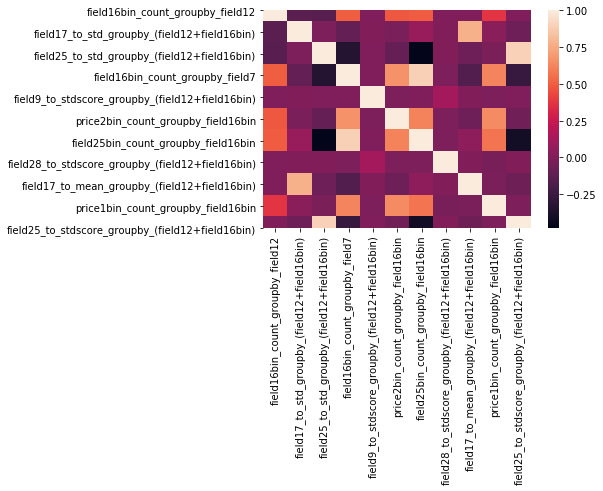

In [23]:

sns.heatmap(best_features.corr())

In [21]:
pd.DataFrame(index=df_col.index,data=df_col)

,field16bin_count_groupby_field12
orderid,
1000000,12678
1000001,60
1000002,16185
1000003,2451
1000004,11430
1000005,21781
1000006,5663
1000007,5792
1000008,14562
